In [1]:
from backtest import do_simulation, daily_potential_pnl
from services.alpaca import AlpacaAssetDataService, AlpacaOptionsDataService
from strategies import *

In [2]:
asset_data_service = AlpacaAssetDataService()
options_data_service = AlpacaOptionsDataService()
asset = "SPY"

## Some full simulations

100%|██████████| 231/231 [04:44<00:00,  1.23s/it]

Skipped 1 days due to incomplete data.


<Axes: xlabel='timestamp'>

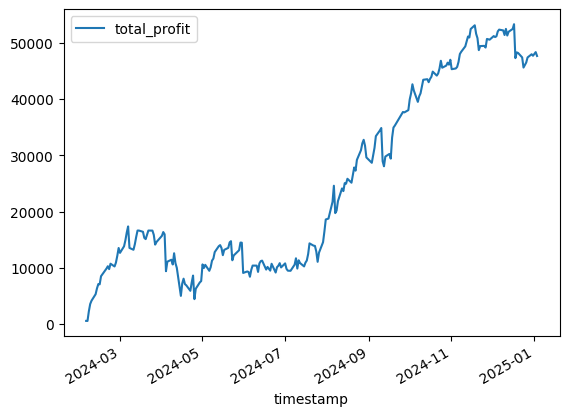

In [ ]:
profit_df, _ = do_simulation(
    datetime(2024, 2, 5),
    datetime(2025, 1, 6),
    asset,
    asset_data_service,
    options_data_service,
    opening_strategy_iron_condor_specific_minute_idx(60),
    closing_strategy_last_n(30),
)

profit_df.plot()

<Axes: xlabel='timestamp'>

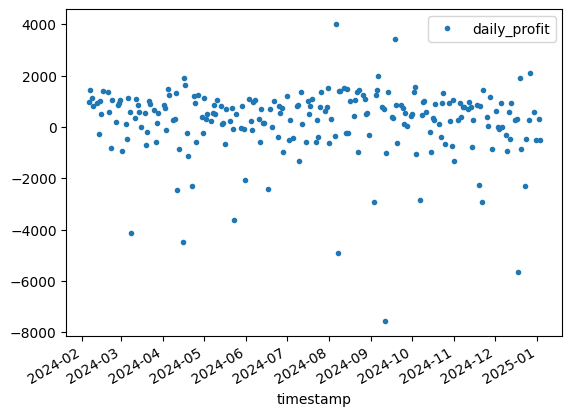

In [14]:
diff_df = profit_df.diff().rename(columns={"total_profit": "daily_profit"})
diff_df.plot(style='.')

Then a stop loss of around $2k sound like a good idea maybe?

100%|██████████| 237/237 [02:42<00:00,  1.46it/s]


Skipped 2 days due to incomplete data.


<Axes: xlabel='timestamp'>

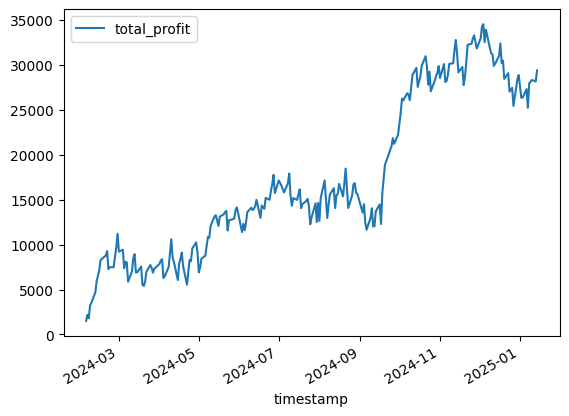

In [ ]:
profit_df, _ = do_simulation(
    datetime(2024, 2, 5),
    datetime(2025, 1, 15),
    asset,
    asset_data_service,
    options_data_service,
    opening_strategy_iron_condor_specific_minute_idx(2),
    closing_strategy_stoploss_or_last_n(2000, 30),
)

profit_df.plot()

<Axes: xlabel='timestamp'>

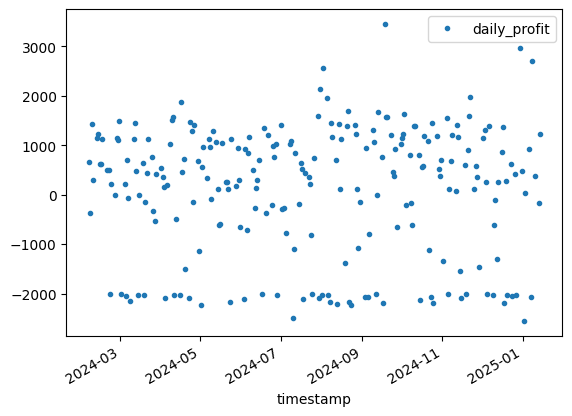

In [7]:
diff_df = profit_df.dropna().diff().rename(columns={"total_profit": "daily_profit"})
diff_df.plot(style='.')

In [8]:
f"Winning rate: {diff_df[diff_df['daily_profit'] > 0].shape[0] / diff_df.shape[0]:.2%}"

'Winning rate: 63.71%'

## Some potential P&L analysis based on daily position movement

In [45]:
# 1. either fetch anew:

daily_movements = daily_potential_pnl(
    datetime(2024, 2, 5),
    datetime(2025, 1, 29),
    asset,
    asset_data_service,
    options_data_service,
    opening_strategy_iron_condor_specific_minute_idx(5),
)

import json
with open("daily_movements_open5.json", "w") as f:
    json.dump([m.tolist() for m in daily_movements], f)


# 2. or load from file:

# import json

# with open("daily_movements_open2.json", "r") as f:
#     daily_movements = json.load(f)
#     daily_movements = [np.array(l) for l in daily_movements]

100%|██████████| 246/246 [04:06<00:00,  1.00s/it]

Skipped 2 days due to incomplete data. (inserted np.nan for them)


In [46]:
daily_movements = [movement for movement in daily_movements if np.isnan(movement).all() == False]
len(daily_movements)

244

In [48]:
import matplotlib.pyplot as plt

In [49]:
EXLUDE_LAST_N = 30  # don't close positions in the last half hour

In [50]:
WAIT_FOR_N_BEFORE_STOPLOSS = 100  # 1 hour 40min

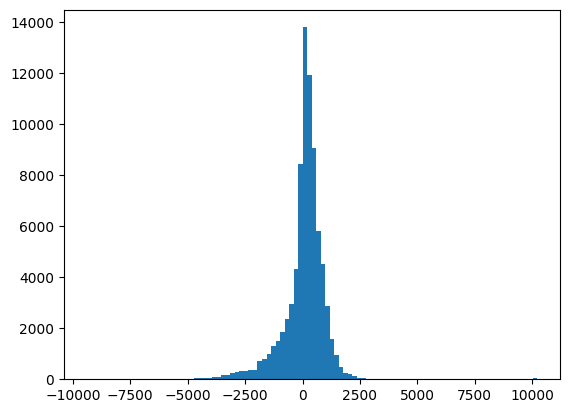

In [51]:
# quick histogram
all_values = [v for daily_values in daily_movements for v in daily_values[:-EXLUDE_LAST_N]]
plt.hist(all_values, bins=100)
plt.show()


<Axes: >

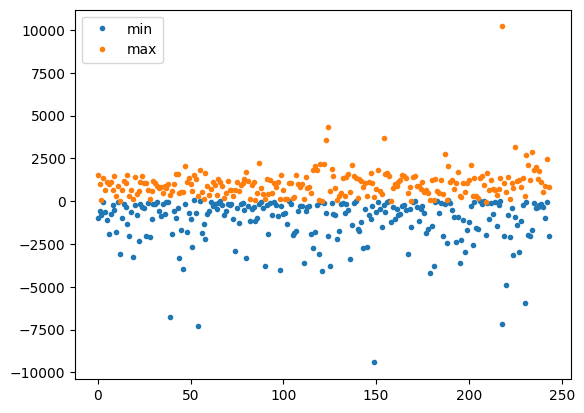

In [52]:
# daily min-max values

daily_min_max = [(min(daily_values[:-EXLUDE_LAST_N]), max(daily_values[:-EXLUDE_LAST_N])) for daily_values in daily_movements]
daily_min_max_df = pd.DataFrame(daily_min_max, columns=["min", "max"])

daily_min_max_df.plot(style='.')

In [53]:
n_days = daily_min_max_df.shape[0]

In [54]:
profit_categories = [np.inf, 2000, 1750, 1600, 1500, 1250, 1200, 1000, 800, 750, 500, 400, 300, 250, 150, 100]
loss_categories = [-100, -150, -250, -300, -400, -500, -750, -800, -1000, -1200, -1250, -1500, -1600, -1750, -2000, -2500, -3000, -4000, -5000, -np.inf]

profit_ratios = {
    cat: sum(
        1 if (daily_movement[:-EXLUDE_LAST_N] >= cat).any() else 0
        for daily_movement in daily_movements
    ) / n_days
    for cat in profit_categories
}

loss_ratios = {
    cat: sum(
        1 if (daily_movement[:-EXLUDE_LAST_N] <= cat).any() else 0
        for daily_movement in daily_movements
    ) / n_days
    for cat in loss_categories
}

profit_ratios, loss_ratios

({inf: 0.0,
  2000: 0.07377049180327869,
  1750: 0.10655737704918032,
  1600: 0.13114754098360656,
  1500: 0.18442622950819673,
  1250: 0.30327868852459017,
  1200: 0.3442622950819672,
  1000: 0.48770491803278687,
  800: 0.5942622950819673,
  750: 0.6188524590163934,
  500: 0.7622950819672131,
  400: 0.819672131147541,
  300: 0.8524590163934426,
  250: 0.8852459016393442,
  150: 0.9221311475409836,
  100: 0.9549180327868853},
 {-100: 0.8729508196721312,
  -150: 0.8114754098360656,
  -250: 0.7090163934426229,
  -300: 0.6680327868852459,
  -400: 0.6229508196721312,
  -500: 0.569672131147541,
  -750: 0.4672131147540984,
  -800: 0.44672131147540983,
  -1000: 0.3975409836065574,
  -1200: 0.3319672131147541,
  -1250: 0.3237704918032787,
  -1500: 0.29098360655737704,
  -1600: 0.2786885245901639,
  -1750: 0.2459016393442623,
  -2000: 0.19262295081967212,
  -2500: 0.12704918032786885,
  -3000: 0.0942622950819672,
  -4000: 0.03278688524590164,
  -5000: 0.020491803278688523,
  -inf: 0.0})

In [55]:
# profit vs loss matrix

profit_loss_matrix = pd.DataFrame(
    {
        profit_cat: [
            sum(
                1 \
                    if closing_strategy_limit_or_stoploss_after_n_or_last_m(
                        profit_cat, loss_cat, WAIT_FOR_N_BEFORE_STOPLOSS, EXLUDE_LAST_N
                    )(daily_movement) > 0 \
                    else 0
                for daily_movement in daily_movements
            ) / n_days
            for loss_cat in loss_categories
        ]
        for profit_cat in profit_categories
    },
    index=loss_categories
)

profit_loss_matrix

,inf,2000.0,1750.0,1600.0,1500.0,1250.0,1200.0,1000.0,800.0,750.0,500.0,400.0,300.0,250.0,150.0,100.0
-100.0,0.290984,0.295082,0.295082,0.295082,0.299180,0.319672,0.319672,0.360656,0.422131,0.430328,0.561475,0.651639,0.696721,0.737705,0.840164,0.897541
-150.0,0.323770,0.327869,0.327869,0.327869,0.331967,0.348361,0.348361,0.381148,0.434426,0.442623,0.569672,0.659836,0.713115,0.754098,0.844262,0.901639
-250.0,0.389344,0.389344,0.389344,0.389344,0.393443,0.413934,0.413934,0.438525,0.495902,0.504098,0.627049,0.704918,0.745902,0.786885,0.860656,0.909836
-300.0,0.393443,0.393443,0.393443,0.393443,0.397541,0.418033,0.418033,0.442623,0.504098,0.512295,0.631148,0.709016,0.750000,0.790984,0.864754,0.913934
-400.0,0.418033,0.418033,0.418033,0.418033,0.422131,0.442623,0.442623,0.463115,0.532787,0.540984,0.651639,0.721311,0.762295,0.803279,0.864754,0.913934
-500.0,0.442623,0.442623,0.442623,0.442623,0.446721,0.471311,0.471311,0.487705,0.557377,0.561475,0.659836,0.729508,0.762295,0.803279,0.864754,0.913934
-750.0,0.512295,0.512295,0.512295,0.512295,0.516393,0.540984,0.540984,0.553279,0.610656,0.614754,0.696721,0.758197,0.790984,0.819672,0.877049,0.922131
-800.0,0.520492,0.520492,0.520492,0.520492,0.524590,0.549180,0.549180,0.561475,0.614754,0.618852,0.700820,0.758197,0.790984,0.819672,0.877049,0.922131
-1000.0,0.536885,0.536885,0.536885,0.536885,0.540984,0.565574,0.565574,0.573770,0.622951,0.627049,0.704918,0.766393,0.799180,0.827869,0.881148,0.926230
-1200.0,0.557377,0.557377,0.557377,0.557377,0.557377,0.581967,0.581967,0.590164,0.639344,0.643443,0.721311,0.782787,0.807377,0.836066,0.885246,0.930328


<Axes: title={'center': 'Win rates for strat waiting for 100 minutes before stoploss'}>

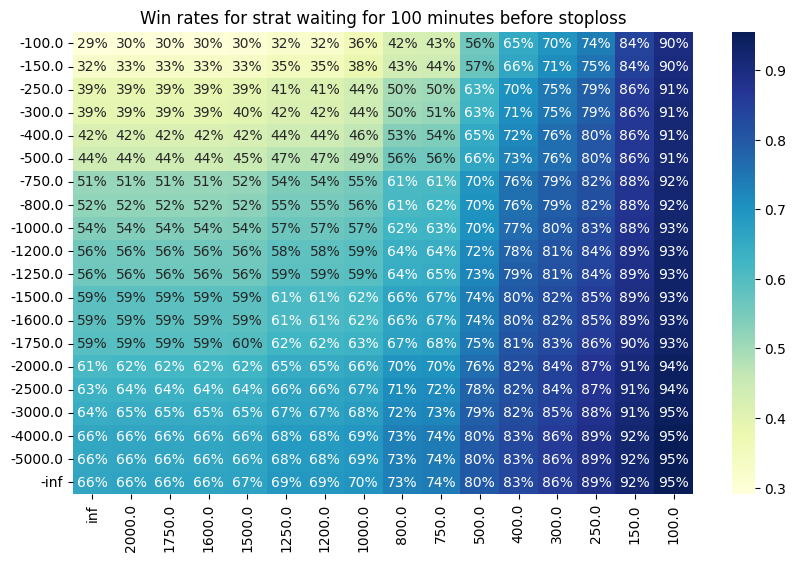

In [56]:
import seaborn as sns

# win rates

plt.figure(figsize=(10, 6))
plt.title(f"Win rates for strat waiting for {WAIT_FOR_N_BEFORE_STOPLOSS} minutes before stoploss")
sns.heatmap(profit_loss_matrix, annot=True, fmt=".0%", cmap="YlGnBu")

In [57]:
# profitable win rates according to Kelly criterion

kelly_profit_loss_matrix = pd.DataFrame(
    {
        profit_cat: [
            1 - abs(profit_cat / (profit_cat - loss_cat)) if not np.isinf(profit_cat) and not np.isinf(loss_cat) else np.nan
            for loss_cat in loss_categories
        ]
        for profit_cat in profit_categories
    },
    index=loss_categories
)

kelly_profit_loss_matrix

,inf,2000.0,1750.0,1600.0,1500.0,1250.0,1200.0,1000.0,800.0,750.0,500.0,400.0,300.0,250.0,150.0,100.0
-100.0,NaN,0.047619,0.054054,0.058824,0.062500,0.074074,0.076923,0.090909,0.111111,0.117647,0.166667,0.200000,0.250000,0.285714,0.400000,0.500000
-150.0,NaN,0.069767,0.078947,0.085714,0.090909,0.107143,0.111111,0.130435,0.157895,0.166667,0.230769,0.272727,0.333333,0.375000,0.500000,0.600000
-250.0,NaN,0.111111,0.125000,0.135135,0.142857,0.166667,0.172414,0.200000,0.238095,0.250000,0.333333,0.384615,0.454545,0.500000,0.625000,0.714286
-300.0,NaN,0.130435,0.146341,0.157895,0.166667,0.193548,0.200000,0.230769,0.272727,0.285714,0.375000,0.428571,0.500000,0.545455,0.666667,0.750000
-400.0,NaN,0.166667,0.186047,0.200000,0.210526,0.242424,0.250000,0.285714,0.333333,0.347826,0.444444,0.500000,0.571429,0.615385,0.727273,0.800000
-500.0,NaN,0.200000,0.222222,0.238095,0.250000,0.285714,0.294118,0.333333,0.384615,0.400000,0.500000,0.555556,0.625000,0.666667,0.769231,0.833333
-750.0,NaN,0.272727,0.300000,0.319149,0.333333,0.375000,0.384615,0.428571,0.483871,0.500000,0.600000,0.652174,0.714286,0.750000,0.833333,0.882353
-800.0,NaN,0.285714,0.313725,0.333333,0.347826,0.390244,0.400000,0.444444,0.500000,0.516129,0.615385,0.666667,0.727273,0.761905,0.842105,0.888889
-1000.0,NaN,0.333333,0.363636,0.384615,0.400000,0.444444,0.454545,0.500000,0.555556,0.571429,0.666667,0.714286,0.769231,0.800000,0.869565,0.909091
-1200.0,NaN,0.375000,0.406780,0.428571,0.444444,0.489796,0.500000,0.545455,0.600000,0.615385,0.705882,0.750000,0.800000,0.827586,0.888889,0.923077


<Axes: title={'center': 'Difference between win rates and Kelly criterion threshold'}>

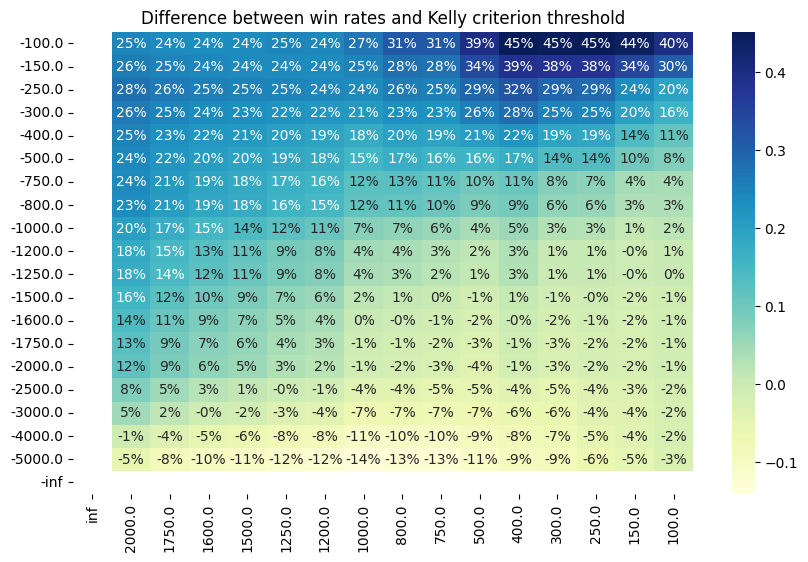

In [58]:
# difference between win rates and Kelly criterion

diff_profit_loss_matrix = profit_loss_matrix - kelly_profit_loss_matrix

plt.figure(figsize=(10, 6))
plt.title("Difference between win rates and Kelly criterion threshold")
sns.heatmap(diff_profit_loss_matrix, annot=True, fmt=".0%", cmap="YlGnBu")

<Axes: title={'center': 'Not reaching limit or stoploss'}>

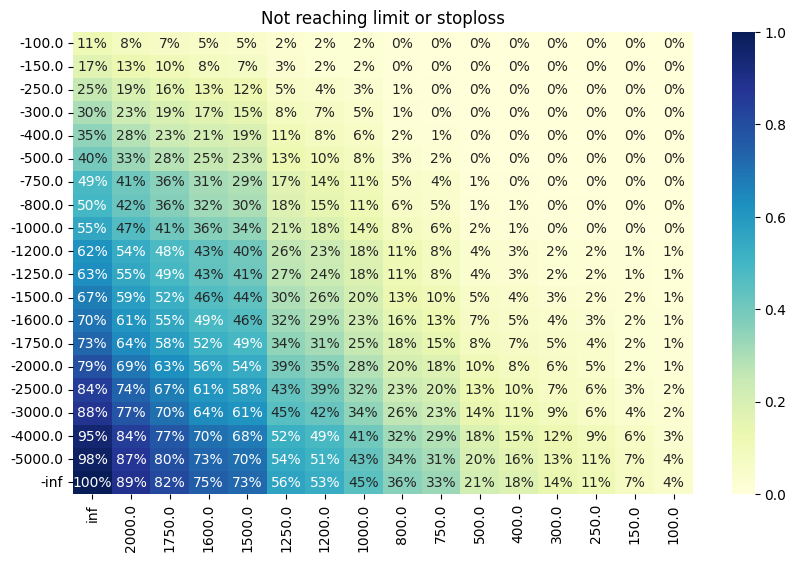

In [59]:
not_reaching_limit_or_stoploss_df = pd.DataFrame(
    {
        profit_cat: [
            sum(
                1 if ((daily_movement >= loss_cat).all() & (daily_movement <= profit_cat).all()) else 0
                for daily_movement in daily_movements
            ) / n_days
            for loss_cat in loss_categories
        ]
        for profit_cat in profit_categories
    },
    index=loss_categories
)

plt.figure(figsize=(10, 6))
plt.title("Not reaching limit or stoploss")
sns.heatmap(not_reaching_limit_or_stoploss_df, annot=True, fmt=".0%", cmap="YlGnBu")

<Axes: title={'center': 'Total profit ($)'}>

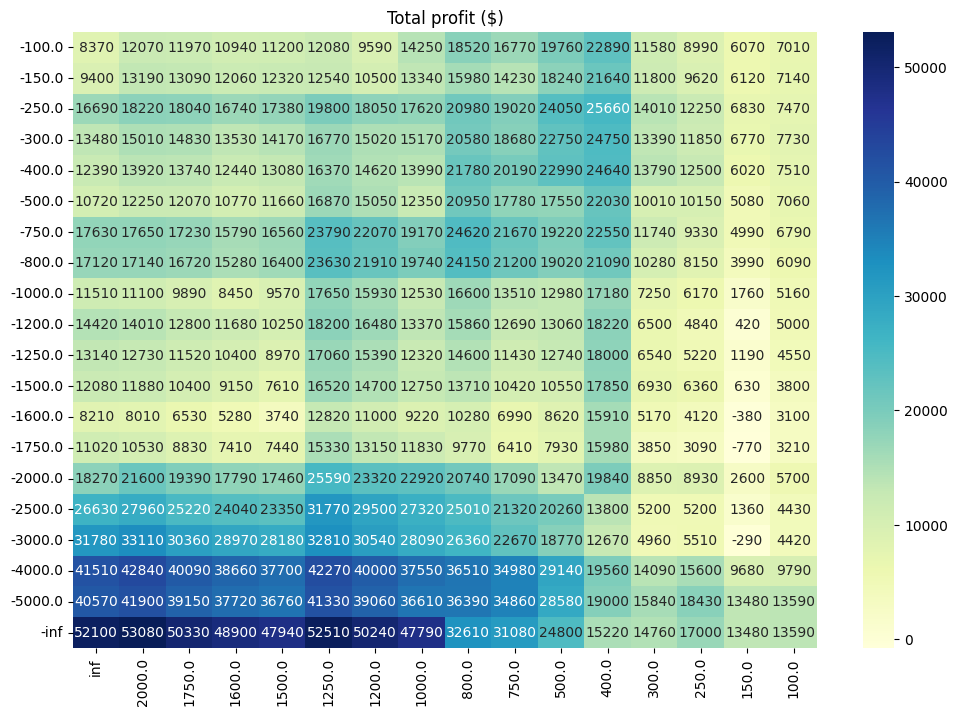

In [60]:
# total profit

total_profit_matrix = pd.DataFrame(
    {
        profit_cat: [
            sum(
                closing_strategy_limit_or_stoploss_after_n_or_last_m(profit_cat, loss_cat, 100, EXLUDE_LAST_N)(daily_movement)
                for daily_movement in daily_movements
            )
            for loss_cat in loss_categories
        ]
        for profit_cat in profit_categories
    },
    index=loss_categories
)

plt.figure(figsize=(12, 8))
plt.title("Total profit ($)")
sns.heatmap(total_profit_matrix, annot=True, fmt=".0f", cmap="YlGnBu")

<Axes: title={'center': 'Cumulative profit for strategy: 1750 limit w/o stop loss'}>

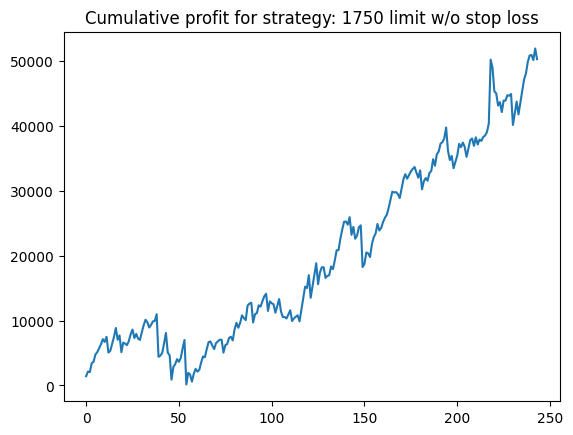

In [61]:
plt.title("Cumulative profit for strategy: 1750 limit w/o stop loss")
pnl = np.array([
    closing_strategy_limit_or_stoploss_after_n_or_last_m(1750, -np.inf, WAIT_FOR_N_BEFORE_STOPLOSS, EXLUDE_LAST_N)(daily_movement)
    for daily_movement in daily_movements
])
sns.lineplot(data=pnl.cumsum())

<Axes: title={'center': 'Cumulative profit for strategy: 400 limit w/ -400 stop loss'}>

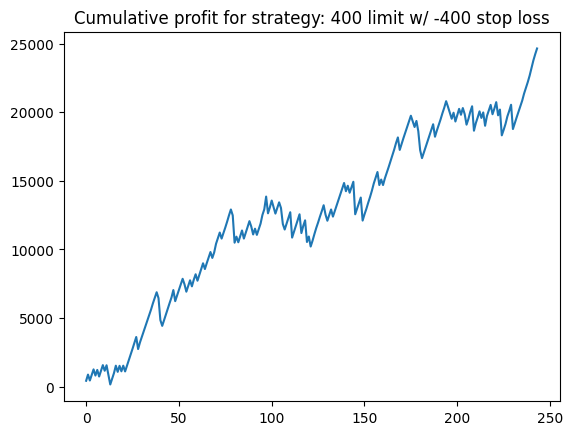

In [62]:
plt.title("Cumulative profit for strategy: 400 limit w/ -400 stop loss")
pnl = np.array([
    closing_strategy_limit_or_stoploss_after_n_or_last_m(
        400, -400, WAIT_FOR_N_BEFORE_STOPLOSS, EXLUDE_LAST_N)(daily_movement)
    for daily_movement in daily_movements
])
sns.lineplot(data=pnl.cumsum())

<Axes: title={'center': 'Cumulative profit for strategy: 150 limit w/o stop loss'}>

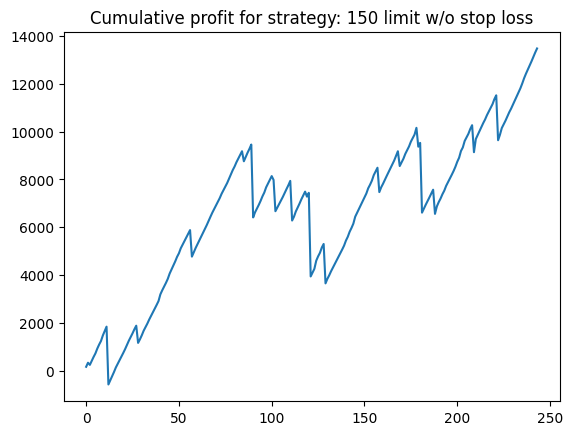

In [63]:
plt.title("Cumulative profit for strategy: 150 limit w/o stop loss")
pnl = np.array([
    closing_strategy_limit_or_stoploss_after_n_or_last_m(
        150, -np.inf, WAIT_FOR_N_BEFORE_STOPLOSS, EXLUDE_LAST_N)(daily_movement)
    for daily_movement in daily_movements
])
sns.lineplot(data=pnl.cumsum())

<Axes: title={'center': 'Biggest losing days ($)'}>

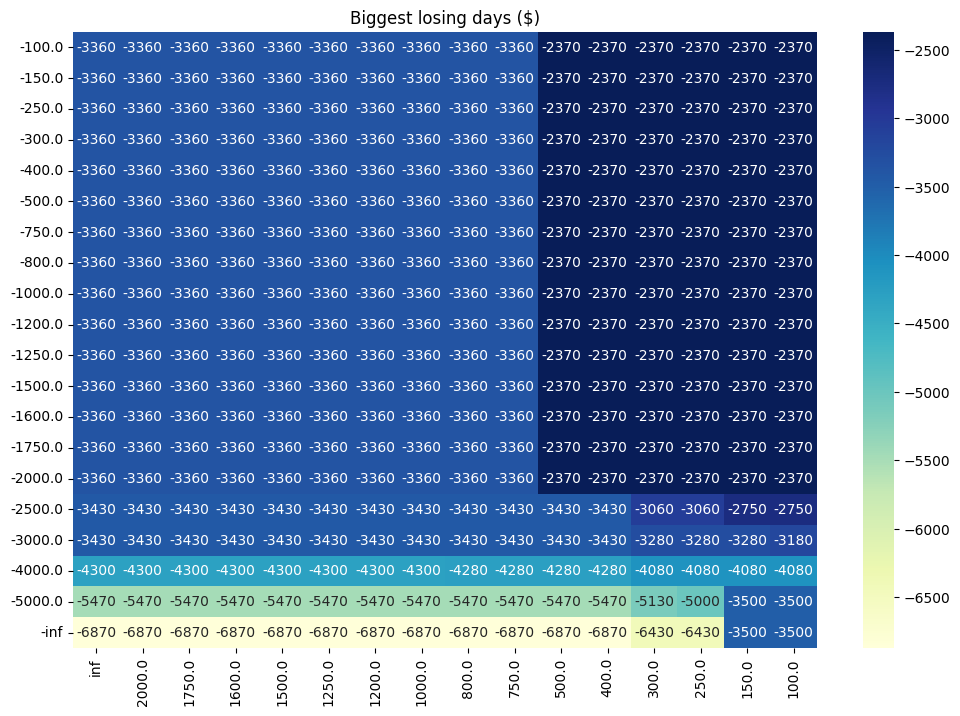

In [64]:
# biggest losing days

top_losers_df = pd.DataFrame(
    {
        profit_cat: [
            min(
                closing_strategy_limit_or_stoploss_after_n_or_last_m(profit_cat, loss_cat, WAIT_FOR_N_BEFORE_STOPLOSS, EXLUDE_LAST_N)(daily_movement)
                for daily_movement in daily_movements
            )
            for loss_cat in loss_categories
        ]
        for profit_cat in profit_categories
    },
    index=loss_categories
)

plt.figure(figsize=(12, 8))
plt.title("Biggest losing days ($)")
sns.heatmap(top_losers_df, annot=True, fmt=".0f", cmap="YlGnBu")

145


<Axes: title={'center': 'Worst Day for 400 / -400 w/ waiting for 100min before stoploss'}>

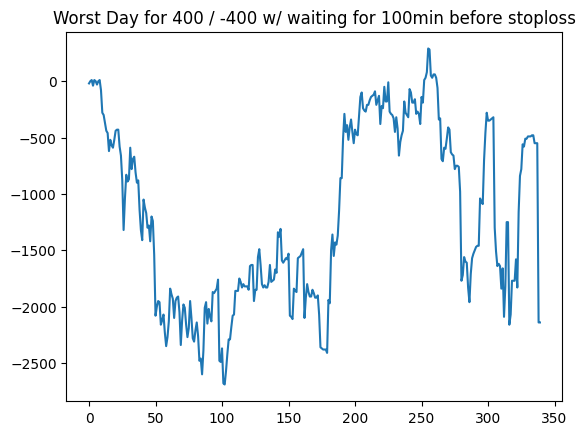

In [65]:
# hmm

daily_pnl = np.array([closing_strategy_limit_or_stoploss_after_n_or_last_m(400, 400, WAIT_FOR_N_BEFORE_STOPLOSS, EXLUDE_LAST_N)(daily_movement) for daily_movement in daily_movements])

plt.title(f"Worst Day for 400 / -400 w/ waiting for {WAIT_FOR_N_BEFORE_STOPLOSS}min before stoploss")
day_idx = np.argmin(daily_pnl)
print(day_idx)
sns.lineplot(daily_movements[day_idx])

index 230 is 7 jan 2025, 2 reports were released that day and i guess at 10:00 ET (17:00 BG) was one of them and brought the bears with it instantly... I guess that can be prevented

209


<Axes: title={'center': 'Worst Day for 400 / -400 w/o waiting before stoploss'}>

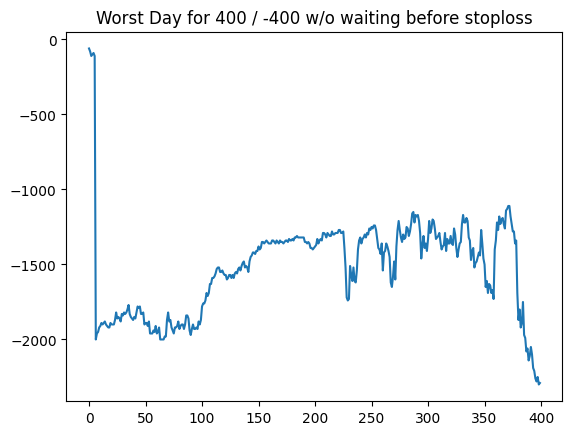

In [66]:
# hmm

daily_pnl = np.array([closing_strategy_limit_or_stoploss_after_n_or_last_m(400, 400, 0, EXLUDE_LAST_N)(daily_movement) for daily_movement in daily_movements])

plt.title("Worst Day for 400 / -400 w/o waiting before stoploss")
day_idx = np.argmin(daily_pnl)
print(day_idx)
sns.lineplot(daily_movements[day_idx])

index 209 is 4 dec 2024... but nothing happened on this day... maybe I have wrong data (e.g. market open timestamp a bit earlier)? I will check this later

In [67]:

# longest negative streak

def count_losing_streak_subarray(arr):
    curr_idx = 0
    total_loss = 0
    while curr_idx < len(arr) and arr[curr_idx] < 0:
        total_loss += arr[curr_idx]
        curr_idx += 1
    return curr_idx, total_loss 


def longest_losing_streak_loss(arr):
    _, longest_negative_streak_money = max(
        count_losing_streak_subarray(arr[i:])
        for i in range(len(arr))
    )
    return longest_negative_streak_money


def longest_losing_streak_days(arr):
    longest_negative_streak_days, _ = max(
        count_losing_streak_subarray(arr[i:])
        for i in range(len(arr))
    )
    return longest_negative_streak_days

def max_losing_streak(arr):
    return min(
        count_losing_streak_subarray(arr[i:])[1]
        for i in range(len(arr))
    )


longest_losing_streak_days(daily_pnl), longest_losing_streak_loss(daily_pnl), max_losing_streak(daily_pnl)

(4, -1670.0000000000005, -2199.9999999999995)

<Axes: title={'center': "Longest losing streak (days) (don't wait until applying stoploss)"}>

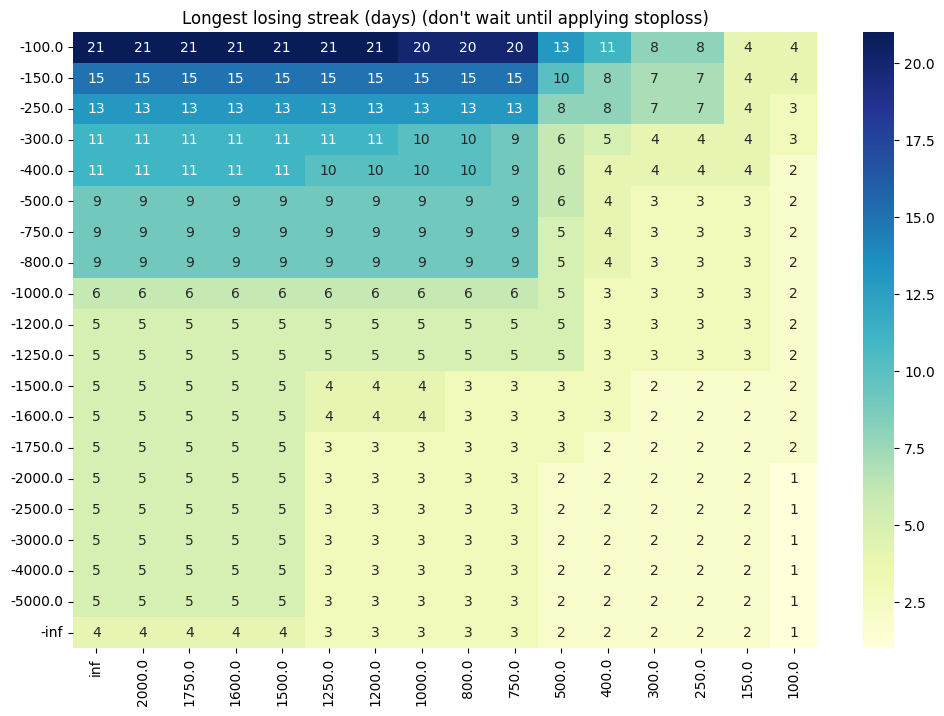

In [68]:
longest_losing_streak_days_df = pd.DataFrame(
    {
        profit_cat: [
            longest_losing_streak_days(np.array([
                closing_strategy_limit_or_stoploss_after_n_or_last_m(profit_cat, loss_cat, 0, EXLUDE_LAST_N)(daily_movement)
                for daily_movement in daily_movements
            ]))
            for loss_cat in loss_categories
        ]
        for profit_cat in profit_categories
    },
    index=loss_categories
)

plt.figure(figsize=(12, 8))
plt.title("Longest losing streak (days) (don't wait until applying stoploss)")
sns.heatmap(longest_losing_streak_days_df, annot=True, fmt=".0f", cmap="YlGnBu")

<Axes: title={'center': "Longest losing streak ($)  (don't wait until applying stoploss)"}>

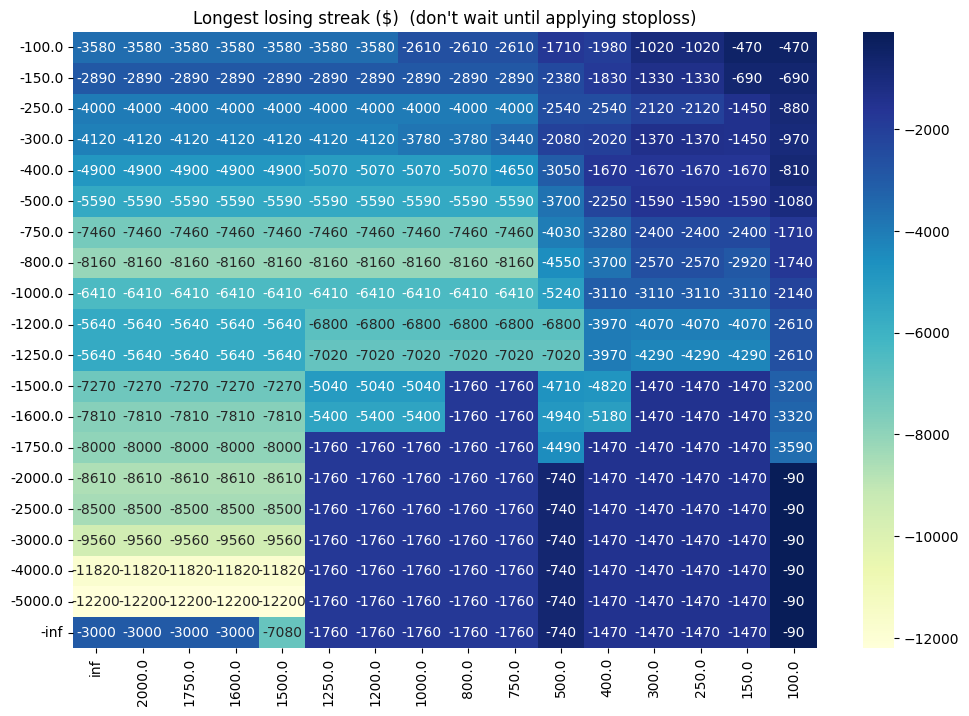

In [69]:
longest_losing_streak_loss_df = pd.DataFrame(
    {
        profit_cat: [
            longest_losing_streak_loss(np.array([
                closing_strategy_limit_or_stoploss_after_n_or_last_m(profit_cat, loss_cat, 0, EXLUDE_LAST_N)(daily_movement)
                for daily_movement in daily_movements
            ]))
            for loss_cat in loss_categories
        ]
        for profit_cat in profit_categories
    },
    index=loss_categories
)

plt.figure(figsize=(12, 8))
plt.title("Longest losing streak ($)  (don't wait until applying stoploss)")
sns.heatmap(longest_losing_streak_loss_df, annot=True, fmt=".0f", cmap="YlGnBu")

<Axes: title={'center': "Worst losing streak ($)  (don't wait until applying stoploss)"}>

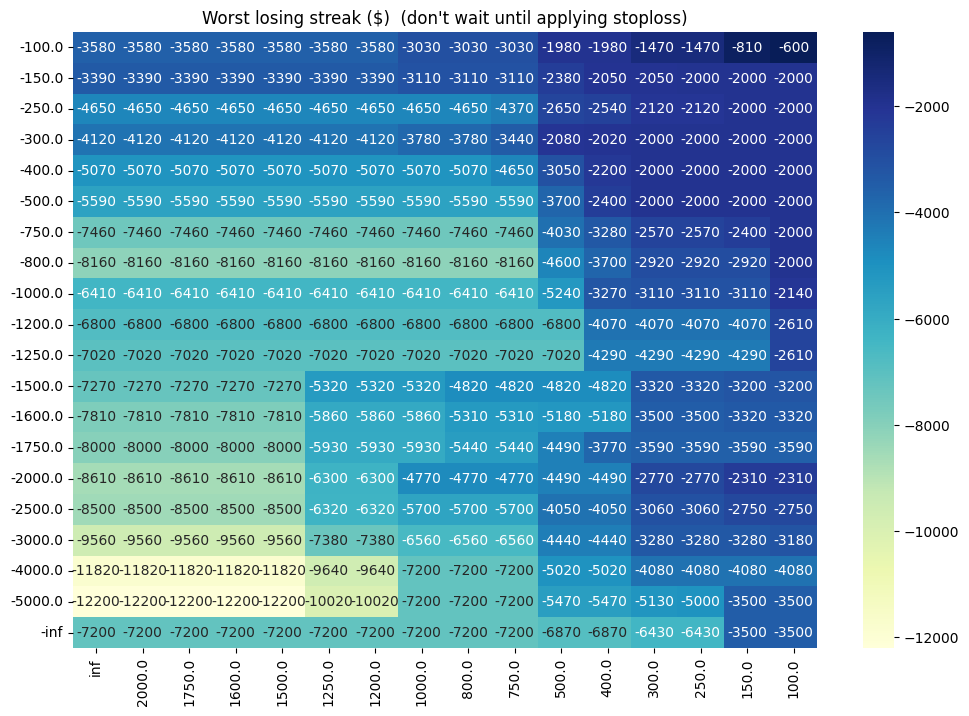

In [70]:
worst_losing_streak_loss_df = pd.DataFrame(
    {
        profit_cat: [
            max_losing_streak(np.array([
                closing_strategy_limit_or_stoploss_after_n_or_last_m(profit_cat, loss_cat, 0, EXLUDE_LAST_N)(daily_movement)
                for daily_movement in daily_movements
            ]))
            for loss_cat in loss_categories
        ]
        for profit_cat in profit_categories
    },
    index=loss_categories
)

plt.figure(figsize=(12, 8))
plt.title("Worst losing streak ($)  (don't wait until applying stoploss)")
sns.heatmap(worst_losing_streak_loss_df, annot=True, fmt=".0f", cmap="YlGnBu")

<Axes: title={'center': 'Longest losing streak (days) (wait for 100min before applying stoploss)'}>

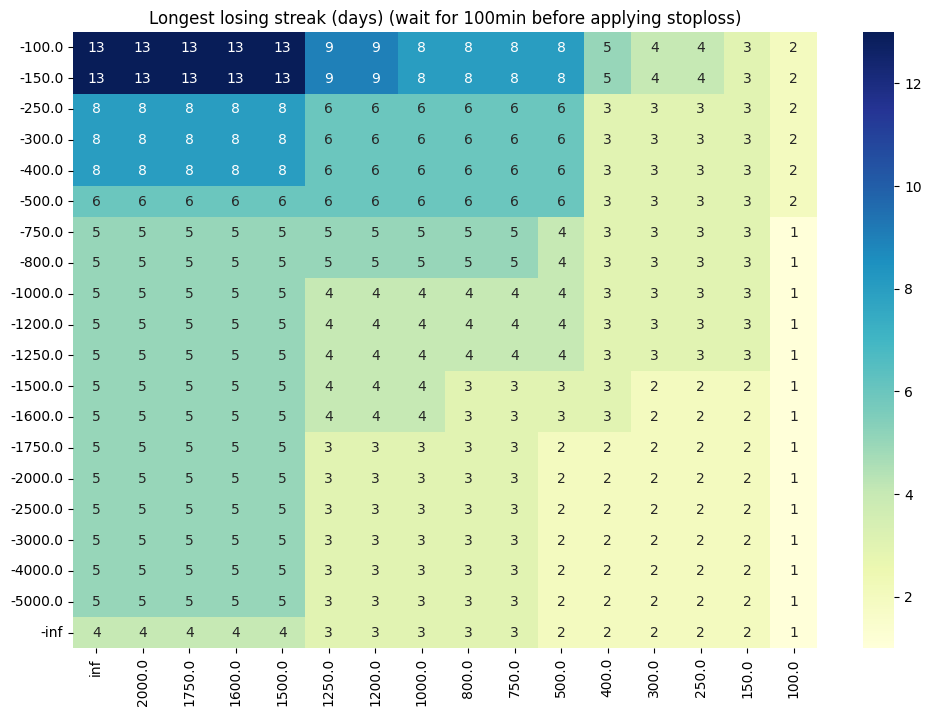

In [71]:
longest_losing_streak_days_df = pd.DataFrame(
    {
        profit_cat: [
            longest_losing_streak_days(np.array([
                closing_strategy_limit_or_stoploss_after_n_or_last_m(profit_cat, loss_cat, WAIT_FOR_N_BEFORE_STOPLOSS, EXLUDE_LAST_N)(daily_movement)
                for daily_movement in daily_movements
            ]))
            for loss_cat in loss_categories
        ]
        for profit_cat in profit_categories
    },
    index=loss_categories
)

plt.figure(figsize=(12, 8))
plt.title(f"Longest losing streak (days) (wait for {WAIT_FOR_N_BEFORE_STOPLOSS}min before applying stoploss)")
sns.heatmap(longest_losing_streak_days_df, annot=True, fmt=".0f", cmap="YlGnBu")

<Axes: title={'center': 'Longest losing streak ($) (wait for 100min before applying stoploss)'}>

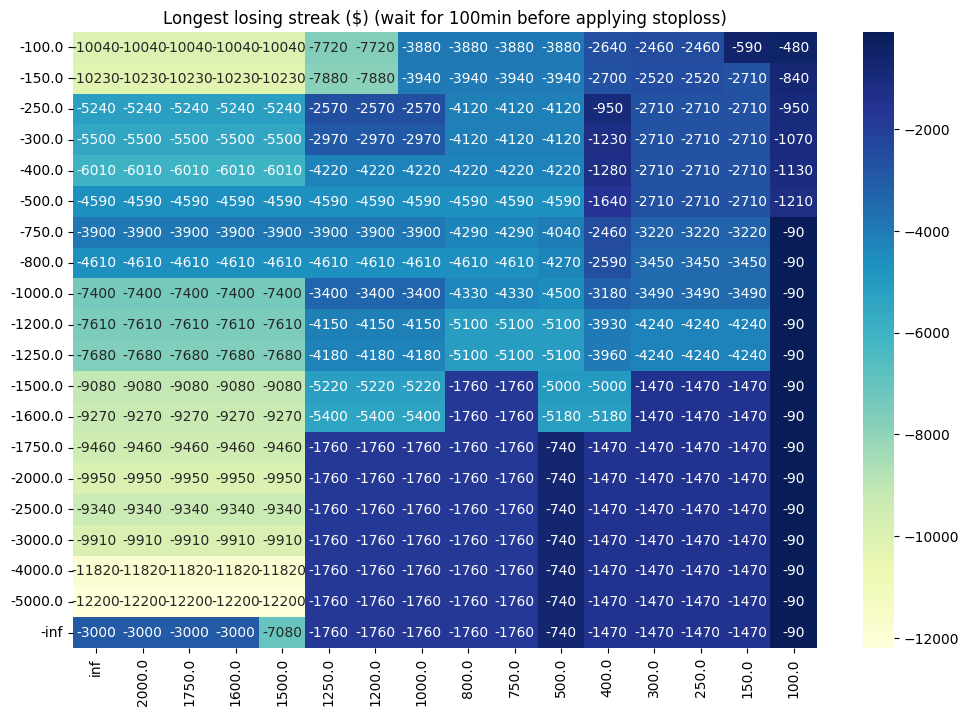

In [72]:
longest_losing_streak_loss_df = pd.DataFrame(
    {
        profit_cat: [
            longest_losing_streak_loss(np.array([
                closing_strategy_limit_or_stoploss_after_n_or_last_m(profit_cat, loss_cat, WAIT_FOR_N_BEFORE_STOPLOSS, EXLUDE_LAST_N)(daily_movement)
                for daily_movement in daily_movements
            ]))
            for loss_cat in loss_categories
        ]
        for profit_cat in profit_categories
    },
    index=loss_categories
)

plt.figure(figsize=(12, 8))
plt.title(f"Longest losing streak ($) (wait for {WAIT_FOR_N_BEFORE_STOPLOSS}min before applying stoploss)")
sns.heatmap(longest_losing_streak_loss_df, annot=True, fmt=".0f", cmap="YlGnBu")

<Axes: title={'center': 'Worst losing streak ($) (wait for 100min before applying stoploss)'}>

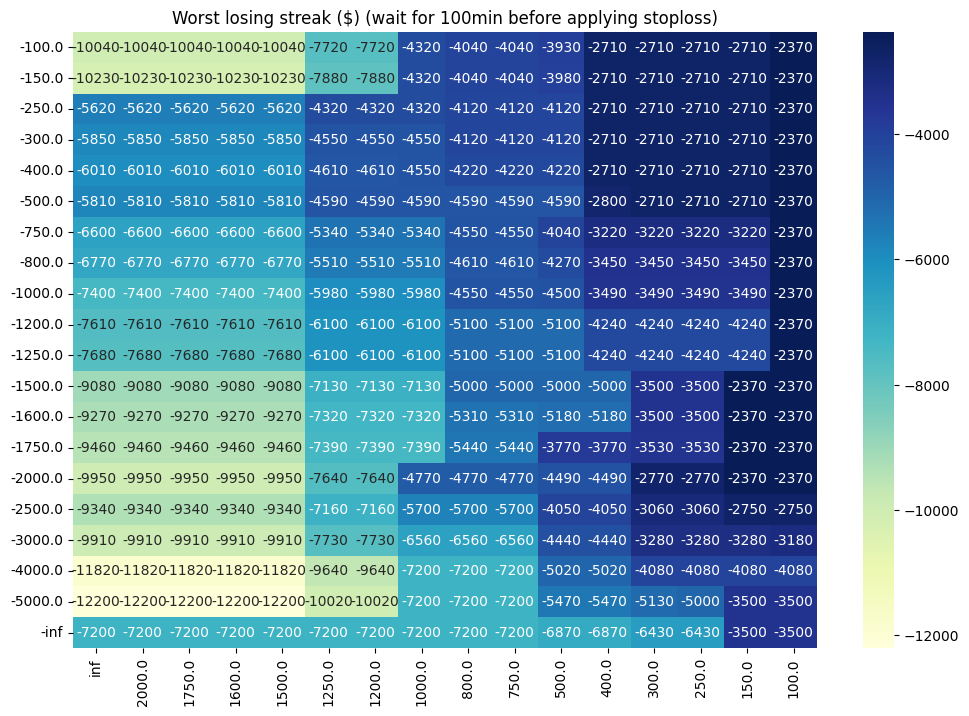

In [73]:
worst_losing_streak_loss_df = pd.DataFrame(
    {
        profit_cat: [
            max_losing_streak(np.array([
                closing_strategy_limit_or_stoploss_after_n_or_last_m(profit_cat, loss_cat, WAIT_FOR_N_BEFORE_STOPLOSS, EXLUDE_LAST_N)(daily_movement)
                for daily_movement in daily_movements
            ]))
            for loss_cat in loss_categories
        ]
        for profit_cat in profit_categories
    },
    index=loss_categories
)

plt.figure(figsize=(12, 8))
plt.title(f"Worst losing streak ($) (wait for {WAIT_FOR_N_BEFORE_STOPLOSS}min before applying stoploss)")
sns.heatmap(worst_losing_streak_loss_df, annot=True, fmt=".0f", cmap="YlGnBu")

In [74]:
def strategy_limit_reach_minute(arr, limit, stoploss, wait_n_before_stoploss, last_n):
    for idx, value in enumerate(arr[:-last_n]):
        if value >= limit:
            return idx
        if value <= stoploss and idx >= wait_n_before_stoploss:
            return -1
    return len(arr) - last_n

<Axes: title={'center': 'Minutes at which limit is reached: 400 limit w/ -400 stop loss'}, ylabel='Count'>

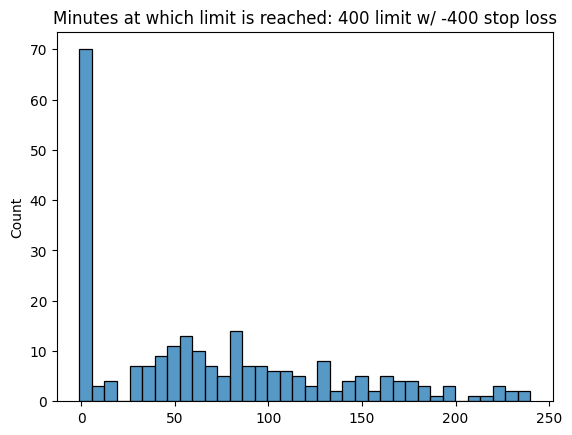

In [75]:
plt.title("Minutes at which limit is reached: 400 limit w/ -400 stop loss")

limit_400_reach_minute = np.array([
    strategy_limit_reach_minute(daily_movement, 400, -400, WAIT_FOR_N_BEFORE_STOPLOSS, EXLUDE_LAST_N)
    for daily_movement in daily_movements
])

sns.histplot(limit_400_reach_minute, bins=36)

<Axes: title={'center': 'Minutes at which limit is reached: 1750 limit w/o stop loss'}, ylabel='Count'>

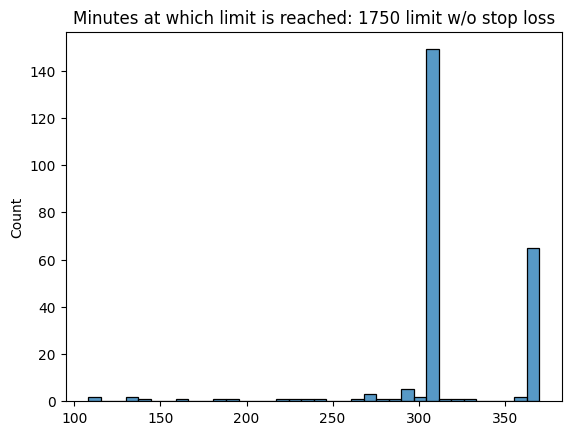

In [76]:
plt.title("Minutes at which limit is reached: 1750 limit w/o stop loss")

limit_1750_reach_minute = np.array([
    strategy_limit_reach_minute(daily_movement, 1750, -np.inf, WAIT_FOR_N_BEFORE_STOPLOSS, EXLUDE_LAST_N)
    for daily_movement in daily_movements
])

sns.histplot(limit_1750_reach_minute, bins=36)

<Axes: title={'center': 'Minutes at which limit is reached: 200 limit w/o stop loss'}, ylabel='Count'>

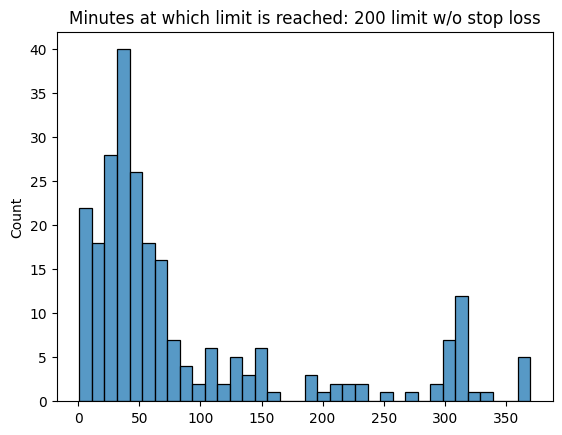

In [77]:
plt.title("Minutes at which limit is reached: 200 limit w/o stop loss")

limit_1750_reach_minute = np.array([
    strategy_limit_reach_minute(daily_movement, 200, -np.inf, WAIT_FOR_N_BEFORE_STOPLOSS, EXLUDE_LAST_N)
    for daily_movement in daily_movements
])

sns.histplot(limit_1750_reach_minute, bins=36)

<Axes: title={'center': 'Minutes at which limit is reached: 400 limit w/o stop loss'}, ylabel='Count'>

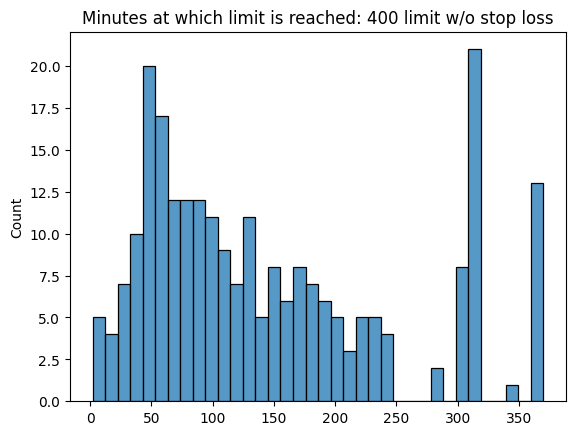

In [78]:
plt.title("Minutes at which limit is reached: 400 limit w/o stop loss")

limit_1750_reach_minute = np.array([
    strategy_limit_reach_minute(
        daily_movement, 400, -np.inf, WAIT_FOR_N_BEFORE_STOPLOSS, EXLUDE_LAST_N)
    for daily_movement in daily_movements
])

sns.histplot(limit_1750_reach_minute, bins=36)

<Axes: title={'center': 'Minutes at which limit is reached: 150 limit w/o stop loss'}, ylabel='Count'>

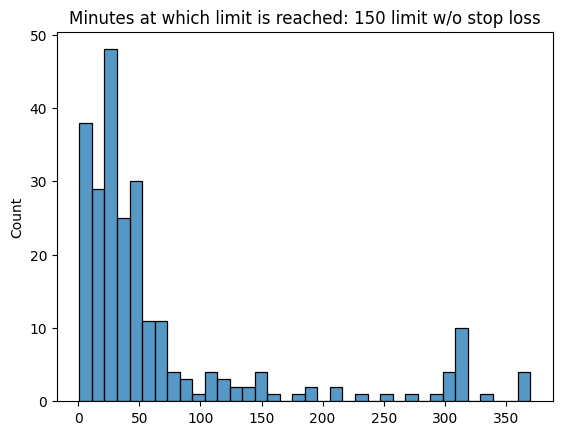

In [79]:
plt.title("Minutes at which limit is reached: 150 limit w/o stop loss")

limit_1750_reach_minute = np.array([
    strategy_limit_reach_minute(
        daily_movement, 150, -np.inf, WAIT_FOR_N_BEFORE_STOPLOSS, EXLUDE_LAST_N)
    for daily_movement in daily_movements
])

sns.histplot(limit_1750_reach_minute, bins=36)